## Cardioid Beads
### 1. Velocity grid data with spatial smoothing

For a 120 x 120 grid of points in 2d

Draw a circle around each point with radius equal to point separation  [or we could try twice the point separation]

KAM: I think it would make sense to make the diameter of the averaging circle equal to the length of an individual fiber/chain.  That seems to be the appropriate length scale from the videos.  Then we could make the spacing between grid points equal to half that value (i.e. the radius of the averaging circle), so that the averaging circles overlap.  This should produce a smoother velocity field for the sake of taking derivatives.

Of course, we’ll need director field (or Q-tensor) as well.  You said you already had that data.  Did you average in a similar way?  

Measure average vx and vy for that data point for beads in that circle
Provide at least 100 frames from last part of the simulation
Output data for each gridpoint in each frame in this form…

i j vx vy 

Let us know if there a better data format.

KAM: This all looks good.

In [1]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import spatial
from tqdm.auto import tqdm

In [ ]:
#filename = "/media/matt/SCRATCH/ActiveMatterWorms/data_02_02_2024/filament_data.npz" # thorin
#filename = "/media/matt/DATA/data_02_02_2024/filament_data.npz" # gimli 
filename = "../data/data_02_02_2024/filament_data.npz" # macbook

#filename = "/media/matt/DATA/data_22_05_2024/filament_data.npz" # gimli
#filename = "../data/data_22_05_2024/filament_data.npz" # macbook
#filename = "/media/matt/DATA/osc_data/data_15_05_2024-2/filament_data.npz" # gimli
data = np.load(filename)
pos_data = data['a']
vel_data = data['b']
print(vel_data.shape)
N = data['a'].shape[1]
nframes = data['a'].shape[0]
print(N)
print(nframes)

In [ ]:
def find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y,num_points=120):
    x_min,x_max,y_min,y_max = bounds
    #radius = X[0,1]-X[0,0]
    radius = 2.0*(X[0,1]-X[0,0])
    pts = np.c_[X.ravel(),Y.ravel()]
    tree = spatial.KDTree(pos_data[iframe,:,0:2])
    vx_avg = np.zeros((num_points,num_points))
    vy_avg = np.zeros((num_points,num_points))
    vmag_avg = np.zeros((num_points,num_points))
    for i in np.arange(num_points):
        for j in np.arange(num_points):
            dd, ii = tree.query([[X[i,j],Y[i,j]]],workers=8,k=len(pos_data[iframe,:,0:2]),distance_upper_bound=radius)
            if np.argmax(dd>x_max**2) > 1:
                vx_avg[i,j] = np.mean(vel_data[iframe,ii[0][:np.argmax(dd>x_max**2)],0])
                vy_avg[i,j] = np.mean(vel_data[iframe,ii[0][:np.argmax(dd>x_max**2)],1])
                vmag_avg[i,j] = np.sqrt(vx_avg[i,j]**2 + vy_avg[i,j]**2)
    return vx_avg,vy_avg,vmag_avg
iframe = 302
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 120),np.linspace(bounds[2], bounds[3], 120))
vx_avg,vy_avg,vmag_avg = find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y)

In [ ]:
fig,axs = plt.subplots(1, 1,figsize=(10,10))
pcm = axs.imshow(vmag_avg,cmap="cividis",alpha=1.0,origin="lower",extent=bounds)#,interpolation='bicubic')
fig.colorbar(pcm, ax=axs)
axs.set_title("Avg. Velocity Mag.")
axs.set_ylim(bounds[2],bounds[3])
axs.set_xlim(bounds[0],bounds[1])
plt.tight_layout()
plt.show()

In [ ]:
def write_avg_vel_ascii(istep,vx,vy,xs,ys,npoints,types="both"):
    filename = "vel_avg_"+str(istep).zfill(4)+".data"
    with open(filename, 'w') as file:
        file.write("# i j x y vx vy\n")
        for i in np.arange(0,npoints):
            for j in np.arange(0,npoints):
                #print(i,j,xs[i,j],ys[i,j],vx[i,j],vy[i,j])
                file.write(str(i)+"\t"+str(j)+"\t"+str(xs[i,j])+"\t"+str(ys[i,j])+"\t"+str(vx[i,j])+"\t"+str(vy[i,j])+"\n")

def write_avg_vel_npz(istep,vx_avg,vy_avg,X,Y):
    filename = "vel_avg_"+str(istep).zfill(4)
    np.savez(filename, x = X, y = Y, vx=vx_avg, vy=vy_avg)
    # npzfile = np.load(filename+".npz")
    # print(npzfile.files)

In [ ]:
for iframe in tqdm(np.arange(1100,1500)):
    num_points = 120
    bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
    X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], num_points),np.linspace(bounds[2], bounds[3], num_points))
    vx_avg,vy_avg,vmag_avg = find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y)
    write_avg_vel_ascii(iframe,vx_avg,vy_avg,X,Y,num_points)
    write_avg_vel_npz(iframe,vx_avg,vy_avg,X,Y)

### 2. Simulated photobleaching: starting at frame 1000, mark a skinny vertical rectangle of beads in a special color. Follow their trajectory with time. 

If that looks good, we are going to also create a vertical line of beads and track the total length along that line as time moves forward. Divide system in horizontal stripes. Find a bead in top stripe, add nearest bead in next stripe, etc. , connect with straight lines and calculate length.
The Lyapunov exponent is the slope of  ln(length) vs time where length is the sum of all the segment lengths. As beads move apart, any line segment exceeding a length limit (2*2^(1/6)) will be broken into two segments by recruiting a new bead in between to add to the list. New bead is the one closest to the segment midpoint.

KAM: Another good way of doing the “photobleaching” would be to bleach a rectangular block of beads on the left of the horizontal axis (i.e. on the opposite side from the cusp).  This rectangle will then get pushed left against the boundary and will spread out along the boundary.   One could then measure the growth rate of the length of the bleached spot along the boundary and the rate of compression of the spot against the boundary (which should both be equal by area conservation.)   These rates should equal the topological entropy/Lyapunov exponent.   The nice thing about this choice of rectangle is that it will persist for a while before getting mixed and distorted in the interior of the cardioid. 

2.1 track the particles in a thin rectangle/square over time

2.2 do the line parts

https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.127.148001


In [ ]:
# box photobleaching

iframe = 1100
length0=0.8
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
box_mesh = X[11:16,3:7],Y[11:16,3:7]#X[12:15,4:6],Y[12:15,4:6]
x_max = np.max(box_mesh[0])
x_min = np.min(box_mesh[0])
y_min = np.min(box_mesh[1])
y_max = np.max(box_mesh[1])
pts_x = []
pts_y = []
pts_id = []
for i in np.arange(len(pos_data[iframe,:,0])):
    x = pos_data[iframe,i,0]
    y = pos_data[iframe,i,1]
    #print(x,y)
    if (x_min <= x <= x_max) and (y_min <= y <= y_max):
        pts_x.append(x)
        pts_y.append(y)
        pts_id.append(i)
        
fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver = ax.quiver(pos_data[iframe,:,0], #x
                   pos_data[iframe,:,1], #y
                   vel_data[iframe,:,0], #u
                   vel_data[iframe,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
# ax.scatter(box_mesh[0],box_mesh[1],color="tab:red",marker='.')
# #ax.scatter(pts_x,pts_y,color="tab:orange",marker='x')
ax.scatter(pos_data[iframe,pts_id,0],pos_data[iframe,pts_id,1],color="tab:orange",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()

In [ ]:
import matplotlib.animation as animation
import matplotlib
from IPython.display import display, HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128
iframe = 1100 #301
fframe = 1500 #500
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
box_mesh = X[11:16,3:7],Y[11:16,3:7]#X[12:15,4:6],Y[12:15,4:6]
x_max = np.max(box_mesh[0])
x_min = np.min(box_mesh[0])
y_min = np.min(box_mesh[1])
y_max = np.max(box_mesh[1])
pts_x = []
pts_y = []
pts_id = []
for i in np.arange(len(pos_data[iframe,:,0])):
    x = pos_data[iframe,i,0] 
    y = pos_data[iframe,i,1]
    #print(x,y)
    if (x_min <= x <= x_max) and (y_min <= y <= y_max):
        pts_x.append(x)
        pts_y.append(y)
        pts_id.append(i)

print(len(pts_id))
fig,ax = plt.subplots(1,1,figsize=(6,6))
# initialize the quiver and scatter plots
lines_x = np.zeros((fframe-iframe,len(pts_id)))
lines_y = np.zeros((fframe-iframe,len(pts_id)))
for frame in range(fframe-iframe):
    for (i,pt) in enumerate(pts_id):
        lines_x[frame,i] = pos_data[iframe+frame,pt,0]
        lines_y[frame,i] = pos_data[iframe+frame,pt,1]

lines = [ax.plot([],[],color="tab:green",linewidth=0.5,zorder=1)[0]  for _ in range(len(pts_id))]
scatter = ax.scatter([], [], color="tab:orange", marker='x',zorder=2)
scatter1 = ax.scatter([], [], color="tab:blue",marker='.',s=4)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
frame_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, 
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),zorder=3)

def init():
    ax.set_xlim(np.min(pos_data[:, :, 0]), np.max(pos_data[:, :, 0]))
    ax.set_ylim(np.min(pos_data[:, :, 1]), np.max(pos_data[:, :, 1]))
    return lines,scatter,scatter1,frame_text

def update(frame):
    for i,line in enumerate(lines):
        x_prev, y_prev = line.get_data()
        x_new = np.append(x_prev, pos_data[frame, pts_id[i], 0])
        y_new = np.append(y_prev, pos_data[frame, pts_id[i], 1])
        lines[i].set_data(x_new,y_new)
    scatter.set_offsets(pos_data[frame, pts_id, :])
    scatter1.set_offsets(pos_data[frame,:,:])
    frame_text.set_text(f'Frame: {frame}')
    return lines,scatter,frame_text
    
anim = animation.FuncAnimation(fig, update, frames=range(iframe,fframe), init_func=init, blit=True, repeat=True)
#plt.show()
#anim.save('animated_scatter_plot1.mp4', writer='ffmpeg', fps=15)
#anim.save('animated_scatter_plot2.mp4', writer='ffmpeg', fps=15)
display(HTML(anim.to_jshtml()))
plt.close()

In [ ]:
# line photobleaching

iframe = 1100 # 301
length0=0.8
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
#X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
X,Y = np.meshgrid(np.linspace(bounds[0],bounds[1],30),np.arange(bounds[2],bounds[3],0.8))
print(X[0,15])
tree = spatial.KDTree(pos_data[iframe,:,0:2])
pb_pts_x = []
pb_pts_y = []
pb_ids = []
for i in np.arange(len(X[:,15])):
    dd,ii = tree.query([[X[i,15],Y[i,25]]],workers=8,k=1,distance_upper_bound=length0)
    if dd < np.Inf:
        pb_pts_x.append(pos_data[iframe,ii,0])
        pb_pts_y.append(pos_data[iframe,ii,1])
        pb_ids.append(ii[0])
        
    #print(dd,ii,sep="\n")


fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver = ax.quiver(pos_data[iframe,:,0], #x
                   pos_data[iframe,:,1], #y
                   vel_data[iframe,:,0], #u
                   vel_data[iframe,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
#ax.scatter(X,Y,color="tab:red",marker='.')
ax.scatter(X[:,15],Y[:,15],color="tab:green",marker='.')
ax.scatter(pb_pts_x,pb_pts_y,color="tab:orange",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()


In [ ]:
import matplotlib.animation as animation
import matplotlib
from IPython.display import display, HTML
from collections import OrderedDict
matplotlib.rcParams['animation.embed_limit'] = 2**128

def calculate_distance(x1, y1, x2, y2):
    # Compute the difference in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1
    # Calculate the distance using the Euclidean distance formula
    distance = np.sqrt(dx**2 + dy**2)
    return distance
    
iframe = 1100 #301
fframe = 1500 #500
length0=0.8
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
#X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
X,Y = np.meshgrid(np.linspace(bounds[0],bounds[1],30),np.arange(bounds[2],bounds[3],0.8))
idx_line = 15
print(X[0,idx_line])
tree = spatial.KDTree(pos_data[iframe,:,0:2])
pb_pts_x = []
pb_pts_y = []
pb_ids = []
dist_list = []
for i in np.arange(len(X[:,idx_line])):
    dd,ii = tree.query([[X[i,idx_line],Y[i,idx_line]]],workers=8,k=1,distance_upper_bound=length0)
    if dd < np.Inf:
        pb_pts_x.append(pos_data[iframe,ii,0])
        pb_pts_y.append(pos_data[iframe,ii,1])
        pb_ids.append(ii[0])
#pb_ids = list(set(pb_ids)) # uniques only
pb_ids = list(OrderedDict.fromkeys(pb_ids))
print(len(pb_ids))
fig,ax = plt.subplots(1,1,figsize=(6,6))

lines = [ax.plot([],[],color="tab:green",linewidth=1,zorder=2)[0]  for _ in range(len(pb_ids))]
scatter = ax.scatter([], [], color="tab:orange", marker='x',zorder=3)
scatter1 = ax.scatter([], [], color="tab:blue",marker='.',s=1,zorder=1)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
frame_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, 
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),zorder=3)

def init():
    ax.set_xlim(np.min(pos_data[:, :, 0]), np.max(pos_data[:, :, 0]))
    ax.set_ylim(np.min(pos_data[:, :, 1]), np.max(pos_data[:, :, 1]))
    return lines,scatter,scatter1,frame_text

def update(frame):
    dist = np.sum([calculate_distance(pos_data[frame,pb_ids[i],0],pos_data[frame,pb_ids[i],1],pos_data[frame,pb_ids[i+1],0],pos_data[frame,pb_ids[i+1],1]) for i in np.arange(len(pb_ids)-1)])
    dist_list.append(dist)
    for i,line in enumerate(lines):
        x_prev, y_prev = line.get_data()
        x_new = np.append(x_prev, pos_data[frame, pb_ids[i], 0])
        y_new = np.append(y_prev, pos_data[frame, pb_ids[i], 1])
        lines[i].set_data(x_new,y_new)
    scatter.set_offsets(pos_data[frame, pb_ids, :])
    scatter1.set_offsets(pos_data[frame,:,:])
    frame_text.set_text(f'Frame: {frame}\n Dist: {dist}')
    return lines,scatter,scatter1,frame_text
    
anim = animation.FuncAnimation(fig, update, frames=range(iframe,fframe), init_func=init, blit=True, repeat=True)
#plt.show()
#anim.save('animated_scatter_plot1.mp4', writer='ffmpeg', fps=15)
#anim.save('animated_scatter_plot2.mp4', writer='ffmpeg', fps=15)
display(HTML(anim.to_jshtml()))
plt.close()

In [ ]:
from scipy.optimize import curve_fit

def fitf(x,a,b):
    return a*x + b
    
fig,ax = plt.subplots(1,1,figsize=(6,6))
flength=400
ax.scatter(np.arange(iframe,iframe+flength),dist_list[:flength])
popt,pcov = curve_fit(fitf,np.arange(iframe,iframe+flength),dist_list[:flength])
print(popt)
ax.plot(np.arange(iframe,iframe+flength),fitf(np.arange(iframe,iframe+flength),popt[0],popt[1]))
ax.set_yscale('log')
plt.show()

### 3. Trajectory analysis:

List x,y position of the head bead only for each filament, one frame at a time, for all frames.

KAM: Yes, that will allow us to apply our Etec algorithm to the bead trajectories.


156.32312590500402


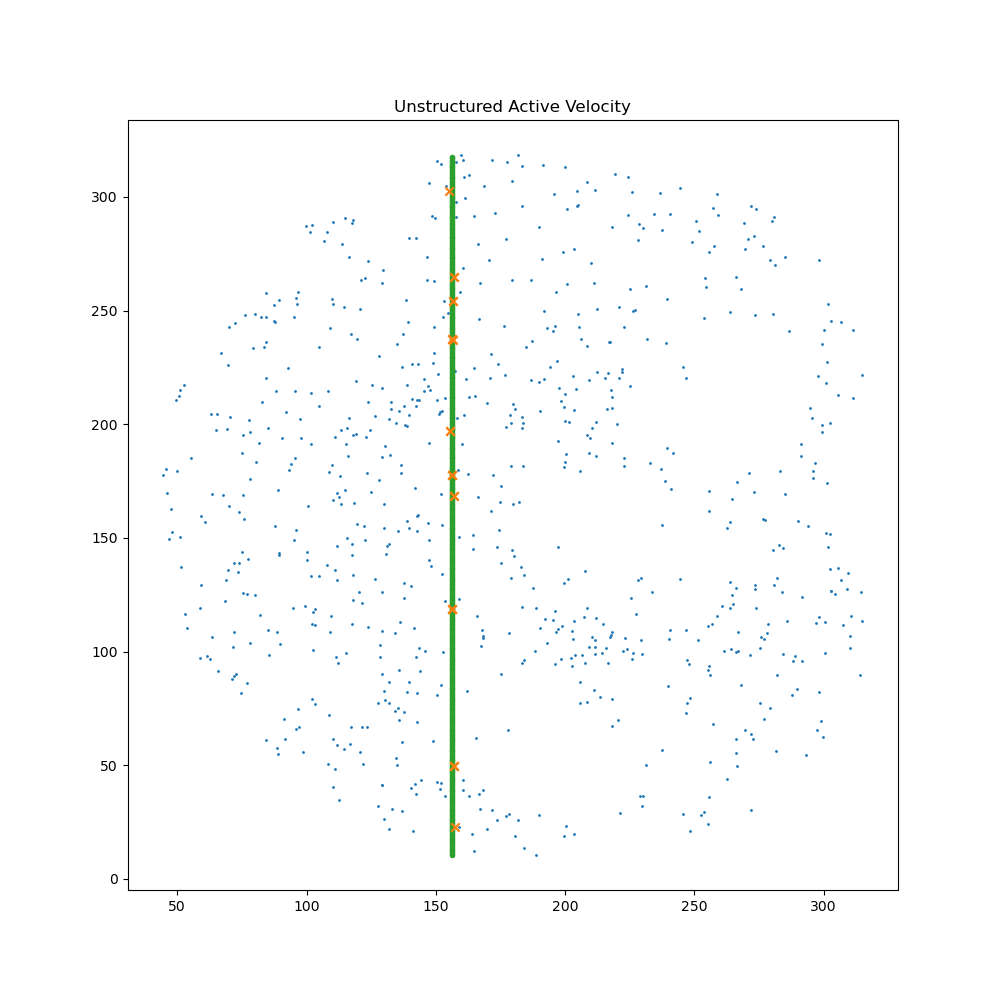

In [2]:
#np.savez_compressed("head_pos_data_02_02", pos_data=pos_data[:,0:-1:nparticles,:])
#np.savez_compressed("head_pos_data_22_05", pos_data=pos_data[:,0:-1:nparticles,:])

data = np.load("head_pos_data_02_02.npz")
pos_data = data['pos_data']

iframe = 1100 # 301
length0=2.0**(1.0/6.0) #0.8
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
#X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
X,Y = np.meshgrid(np.linspace(bounds[0],bounds[1],30),np.arange(bounds[2],bounds[3],0.8))
idx_line = 12
print(X[0,idx_line])
tree = spatial.KDTree(pos_data[iframe,:,0:2])
pb_pts_x = []
pb_pts_y = []
pb_ids = []
for i in np.arange(len(X[:,idx_line])):
    dd,ii = tree.query([[X[i,idx_line],Y[i,idx_line]]],workers=8,k=1,distance_upper_bound=length0)
    if dd < np.Inf:
        pb_pts_x.append(pos_data[iframe,ii,0])
        pb_pts_y.append(pos_data[iframe,ii,1])
        pb_ids.append(ii)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(pos_data[iframe,:,0],pos_data[iframe,:,1],color="tab:blue",marker='.',s=4)
ax.scatter(X[:,idx_line],Y[:,idx_line],color="tab:green",marker='.')
ax.scatter(pb_pts_x,pb_pts_y,color="tab:orange",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()


[array([563]), array([357]), array([357]), array([357]), array([776]), array([776]), array([776]), array([461]), array([461]), array([479]), array([479]), array([479]), array([437]), array([437]), array([719]), array([248]), array([248]), array([160]), array([160]), array([716]), array([716]), array([707])]


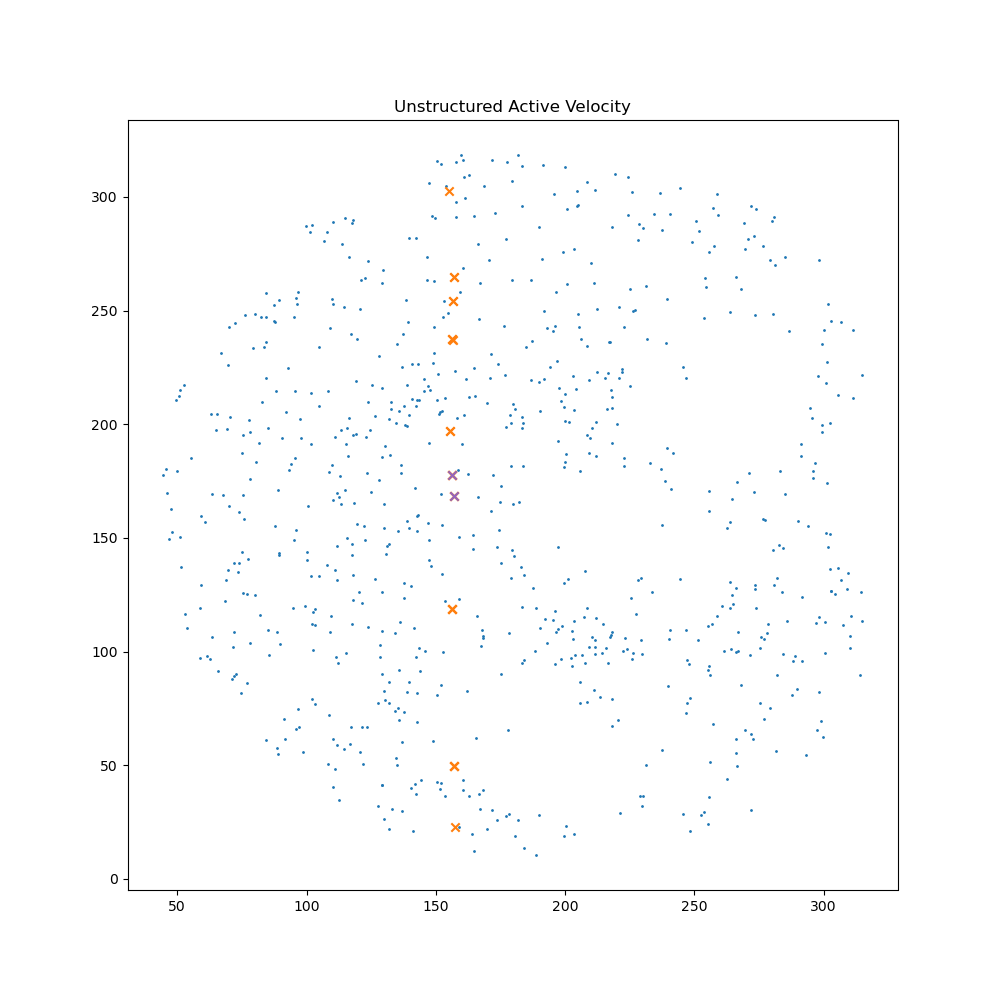

[array([461]), array([479])]


In [3]:
print(pb_ids)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(pos_data[iframe,:,0],pos_data[iframe,:,1],color="tab:blue",marker='.',s=4)
ax.scatter(pos_data[iframe,pb_ids,0],pos_data[iframe,pb_ids,1],color="tab:orange",marker='x')
ax.scatter(pos_data[iframe,pb_ids[8:10],0],pos_data[iframe,pb_ids[8:10],1],color="tab:purple",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()
print(pb_ids[8:10])

[array([563]), array([357]), array([357]), array([357]), array([776]), array([776]), array([776]), array([461]), array([461]), array([479]), array([479]), array([479]), array([437]), array([437]), array([719]), array([248]), array([248]), array([160]), array([160]), array([716]), array([716]), array([707])]


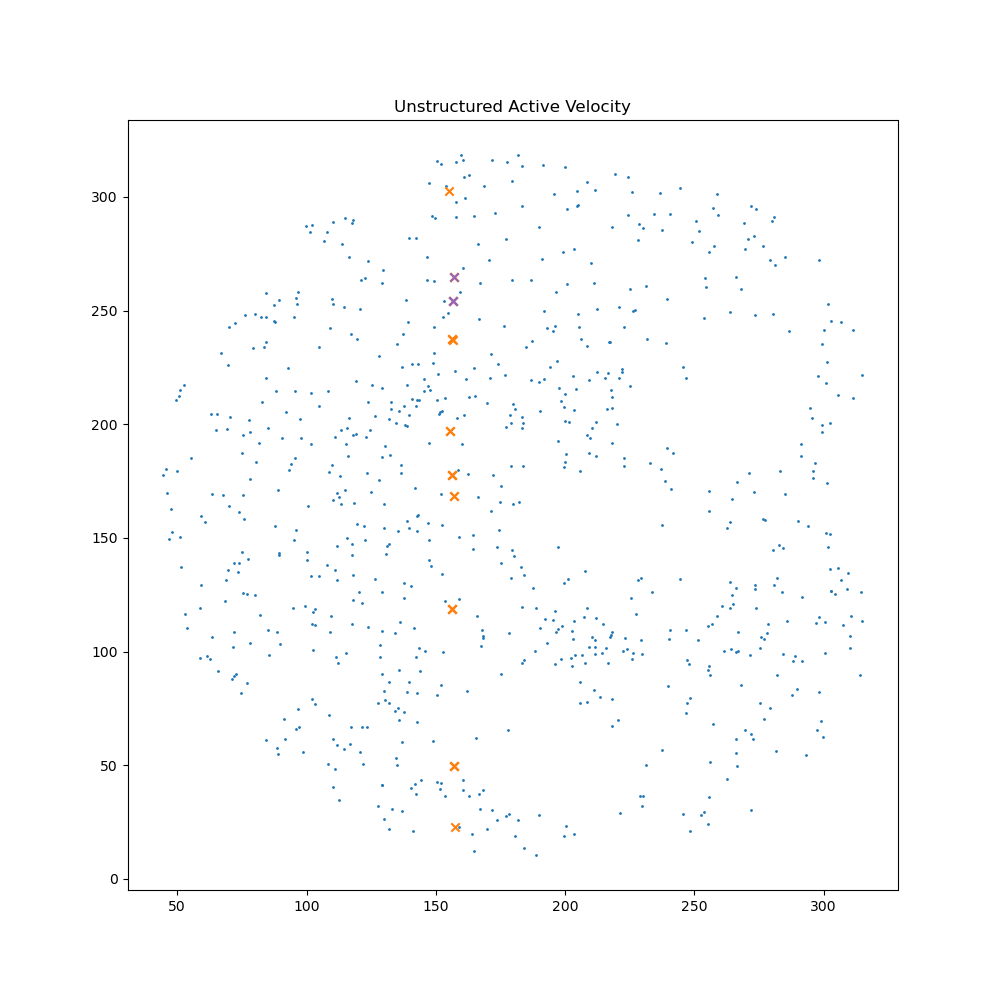

[array([160]), array([160]), array([716])]


In [13]:
print(pb_ids)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(pos_data[iframe,:,0],pos_data[iframe,:,1],color="tab:blue",marker='.',s=4)
ax.scatter(pos_data[iframe,pb_ids,0],pos_data[iframe,pb_ids,1],color="tab:orange",marker='x')
ax.scatter(pos_data[iframe,pb_ids[17:20],0],pos_data[iframe,pb_ids[17:20],1],color="tab:purple",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()
print(pb_ids[17:20])

index list particles before  [461, 479]
399 5.899578116636214
index list particles after  [461, 399, 479]


/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_62586/4124243285.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idl = [int(i) for i in pb_ids[8:10]]
/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_62586/4124243285.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dd,ii = tree.query([float(xm),float(ym)],workers=8,k=len(pos_data[iframe,:,1]))#,distance_upper_bound=radius)


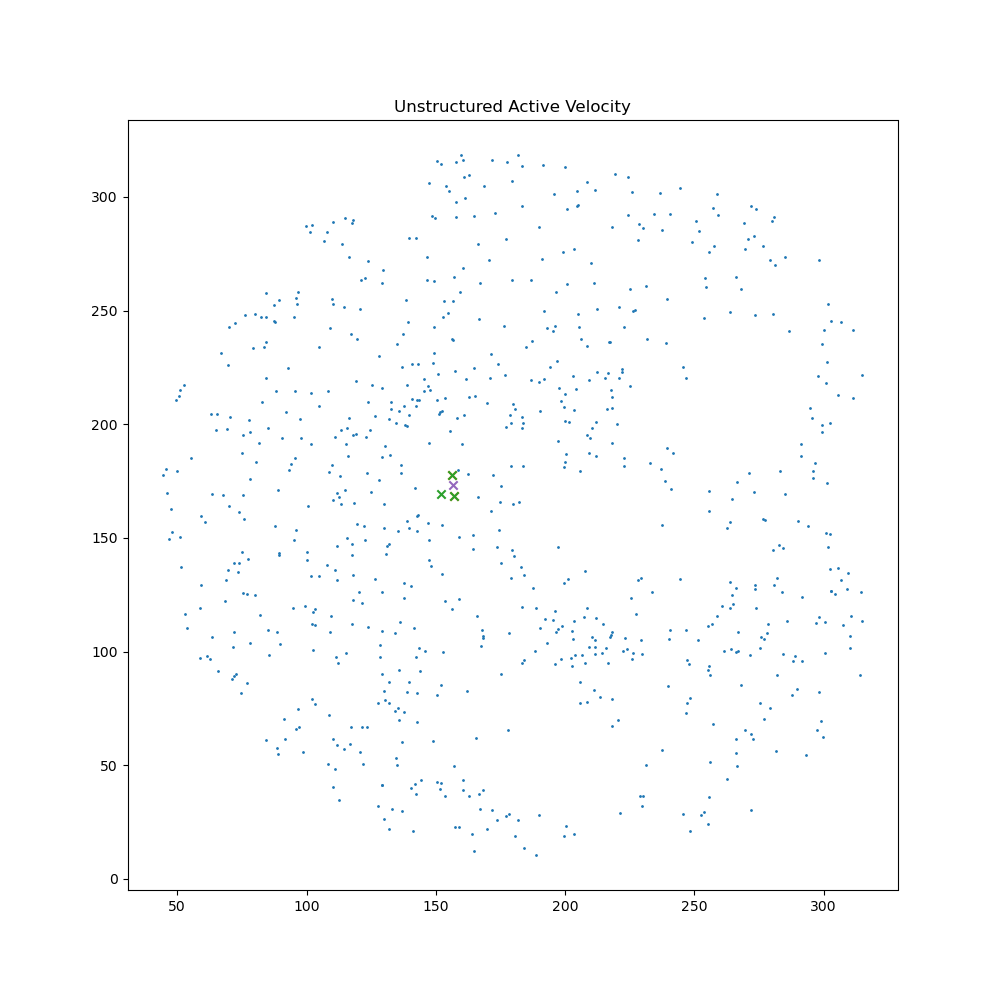

In [4]:
def find_midpoint(x1,y1,x2,y2):
    xm = (x1 + x2) / 2
    ym = (y1 + y2) / 2
    return xm,ym

def calculate_distance(x1, y1, x2, y2):
    # Compute the difference in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1
    # Calculate the distance using the Euclidean distance formula
    distance = np.sqrt(dx**2 + dy**2)
    return distance

tree = spatial.KDTree(pos_data[iframe,:,0:2])

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(pos_data[iframe,:,0],pos_data[iframe,:,1],color="tab:blue",marker='.',s=4)
ax.scatter(pos_data[iframe,pb_ids[8:10],0],pos_data[iframe,pb_ids[8:10],1],color="tab:orange",marker='x')

xm,ym = find_midpoint(pos_data[iframe,pb_ids[8],0],pos_data[iframe,pb_ids[8],1],pos_data[iframe,pb_ids[9],0],pos_data[iframe,pb_ids[9],1])
ax.scatter(xm,ym,color="tab:purple",marker="x")

radius = calculate_distance(xm,ym,pos_data[iframe,pb_ids[8],0],pos_data[iframe,pb_ids[8],1])
idl = [int(i) for i in pb_ids[8:10]]
print("index list particles before ",idl)

dd,ii = tree.query([float(xm),float(ym)],workers=8,k=len(pos_data[iframe,:,1]))#,distance_upper_bound=radius)
for i in np.arange(len(ii)):
    if ii[i] in idl:
        # particle already exists in photobleached line
        continue
    else:
        print(ii[i],dd[i])
        idl.insert(1,ii[i])
        break
#print(dd,ii)
# while add_nn:
#     dd,ii = tree.query([float(xm),float(ym)],workers=8,k=1+nn_offset,distance_upper_bound=radius)
#     print(nn_offset)
#     print(dd,ii,sep="\n")
#     if nn_offset == 0:
#         if ii in idl:
#             nn_offset += 1
#         if dd == np.Inf:
#             nn_offset += 1
#     else:
#         if dd < np.Inf:
#             if all([i in idl for i in ii]) == False:
#                 idl.insert(nn_offset-1,ii[-1])
#                 add_nn = False
#             else:
#                 nn_offset += 1
#         else:
#             nn_offset += 1
#     if nn_offset > 15:
#         break
    
#need to return the nearest neighbor that does not exist in the existing list of points
print("index list particles after ",idl)
ax.scatter(pos_data[iframe,idl,0],pos_data[iframe,idl,1],color="tab:green",marker='x')

ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
plt.show()

In [25]:
import matplotlib.animation as animation
import matplotlib
from IPython.display import display, HTML
from collections import OrderedDict #pb_ids = list(OrderedDict.fromkeys(pb_ids))
matplotlib.rcParams['animation.embed_limit'] = 2**128
iframe = 1100 #301
fframe = 1120#2100 #500
pts_id = [int(i) for i in pb_ids[17:20]]
pts_id = list(OrderedDict.fromkeys(pts_id))
print(pts_id)
length0 =  2.0**(1.0/6.0)
fig,ax = plt.subplots(1,1,figsize=(6,6))

lines = [ax.plot([],[],color="tab:green",linewidth=0.5,zorder=1)[0]  for _ in range(len(pts_id))]
scatter2 = ax.scatter([], [], color="tab:orange", marker='x',zorder=2)
scatter1 = ax.scatter([],[],color = "tab:blue",marker='.',s=4,zorder=3)
scatter_mp = ax.scatter([],[],color = "tab:purple",marker="x",zorder=3)
plot1, = ax.plot([],[],color="tab:purple",linewidth=1.0,zorder=1)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Active Velocity")
frame_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, 
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),zorder=3)
    
def init():
    ax.set_xlim(np.min(pos_data[:, :, 0]), np.max(pos_data[:, :, 0]))
    ax.set_ylim(np.min(pos_data[:, :, 1]), np.max(pos_data[:, :, 1]))
    return lines,scatter1,scatter2,scatter_mp,plot1,frame_text

def update(frame,pts_id):
    tree = spatial.KDTree(pos_data[iframe,:,0:2])
    dlist = []
    pts_id_new = pts_id
    if frame > iframe:
        for i in np.arange(len(pts_id)-1):
            x1,y1 = pos_data[frame,pts_id[i],0],pos_data[frame,pts_id[i],1]
            x2,y2 = pos_data[frame,pts_id[i+1],0],pos_data[frame,pts_id[i+1],1]
            dist = calculate_distance(x1,y1,x2,y2)
            dlist.append(dist)
            xm,ym = find_midpoint(x1,y1,x2,y2)
            search_radius = calculate_distance(xm,ym,x1,y1)
            dd,ii = tree.query([float(xm),float(ym)],workers=8,k=len(pos_data[iframe,:,1]),distance_upper_bound=search_radius)
            for idx in np.arange(len(ii)):
                if i < 800 and ii[i] in pts_id:
                    # particle already exists in photobleached line
                    continue
                else:
                    #print(ii[idx],dd[idx])
                    if dd[idx] < search_radius:
                        pts_id_new.insert(i+1,ii[idx]) # position,value
                        break
                    else:
                        break
    #pts_id = list(OrderedDict.fromkeys(pts_id_new))
    print("Frame ",frame,pts_id,sum(dlist))
    # for i,line in enumerate(lines):
    #     x_prev, y_prev = line.get_data()
    #     x_new = np.append(x_prev, pos_data[frame, pts_id[i], 0])
    #     y_new = np.append(y_prev, pos_data[frame, pts_id[i], 1])
    #     lines[i].set_data(x_new,y_new)
    scatter2.set_offsets(pos_data[frame, pts_id, :])
    scatter1.set_offsets(pos_data[frame,:,:])
    #plot1.set_data(pos_data[frame,pts_id,:])
    frame_text.set_text(f'Frame: {frame} \nDist: {sum(dlist)}')
    return lines,scatter1,scatter2,scatter_mp,plot1,frame_text

anim = animation.FuncAnimation(fig, update, frames=range(iframe,fframe),fargs=(pts_id,),init_func=init, blit=True, repeat=True)
#plt.show()
#anim.save('animated_scatter_plot1.mp4', writer='ffmpeg', fps=15)
#anim.save('animated_scatter_plot2.mp4', writer='ffmpeg', fps=15)
display(HTML(anim.to_jshtml()))
plt.close()

/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_62586/3676521275.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pts_id = [int(i) for i in pb_ids[17:20]]


[160, 716]
Frame  1100 [160, 716] 0
Frame  1101 [160, 308, 716] 9.230431481521544
Frame  1102 [160, 308, 716, 716] 15.097504361521809
Frame  1103 [160, 308, 716, 716, 716] 18.99367817155917
Frame  1104 [160, 308, 716, 716, 716, 716] 20.64178004839553
Frame  1105 [160, 403, 403, 403, 403, 403, 308, 716, 716, 716, 716] 59.23496920800747
Frame  1106 [160, 403, 403, 403, 403, 403, 308, 545, 716, 716, 716, 716, 716] 46.1108781008274
Frame  1107 [160, 403, 403, 403, 403, 403, 308, 403, 403, 403, 403, 403, 403, 545, 716, 716, 716, 716, 716] 94.0053489938693
Frame  1108 [160, 403, 403, 403, 403, 403, 308, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 545, 716, 716, 716, 716, 716] 151.88161348913246
Frame  1109 [160, 403, 403, 403, 403, 403, 308, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 545, 716, 716, 716, 716, 716] 142.84233398648382
Frame  1110 [160, 403, 403, 403, 403, 403, 308, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 4

In [ ]:
i = 2
a = [1,2,3,4,5]
a.insert(2,i)
a

In [ ]:
len([2])